In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, pareto
from matplotlib import colormaps 
import itertools
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from scipy import interpolate
import pandas as pd
from scipy.ndimage import gaussian_filter1d


import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

def remove_nan_values(x_values, y_values):
    """
    Remove NaN values from y_values and the corresponding indices from x_values.

    Parameters:
    x_values (list or np.array): The x-values.
    y_values (list or np.array): The y-values from which to remove NaN values.

    Returns:
    tuple: Two lists, the first with NaN-free x_values and the second with NaN-free y_values.
    """
    cleaned_x_values = [x for x, y in zip(x_values, y_values) if not np.isnan(y)]
    cleaned_y_values = [y for y in y_values if not np.isnan(y)]
    return cleaned_x_values, cleaned_y_values
"""    leny = len(y_values)
    for i in range(leny):
        if np.isnan(y_values[i]):
            del y_values[i]
            del x_values[i]
    return x_values, y_values
"""

def smooth_posterior(x_values, posterior_values, sigma=2):
    """
    Smooth the posterior values using a Gaussian filter.

    Parameters:
    x_values (np.array): The x-values of the posterior.
    posterior_values (np.array): The posterior values to be smoothed.
    sigma (float): The standard deviation for the Gaussian filter. Default is 2.

    Returns:
    np.array: The smoothed posterior values.
    """
    smoothed_posterior = gaussian_filter1d(posterior_values, sigma)
    return x_values, smoothed_posterior

#HELPER FUNCTIONS
def sort_linked_lists(list1, list2):
    # Pair corresponding elements from both lists
    paired_lists = list(zip(list1, list2))

    # Sort based on the first list
    sorted_pairs = sorted(paired_lists, key=lambda x: x[0])

    # Unpack the sorted pairs back into the original lists
    sorted_list1, sorted_list2 = zip(*sorted_pairs)

    return list(sorted_list1), list(sorted_list2)

def conf_interval(fluxes, probs):

    # Assuming you have your x-values and posterior density values
    x_values = fluxes  # Your x-values
    posterior_density = probs  # Corresponding posterior density values
    # Compute the cumulative distribution function (CDF)
    cumulative_probabilities = np.cumsum(posterior_density)  # Numerical integration
    # Normalize the cumulative probabilities
    normalized_cumulative_probabilities = cumulative_probabilities / cumulative_probabilities[-1]
    # Find the x-values corresponding to the 2.5th and 97.5th percentiles
    lower_bound = np.interp(0.025, normalized_cumulative_probabilities, x_values)
    upper_bound = np.interp(0.975, normalized_cumulative_probabilities, x_values)
    return lower_bound, upper_bound

def remove_above_threshold(list1, list2, threshold):
    filtered_list1 = []
    filtered_list2 = []
    
    for val1, val2 in zip(list1, list2):
        if val1 <= threshold:
            filtered_list1.append(val1)
            filtered_list2.append(val2)
    
    return filtered_list1, filtered_list2


def mortlock_post(F_hat, n):
    #average noise 
    if n!= 1:
        F_conf = 0.1 * n**(2/3)
        noise = (1.5/-0.5 * 0.1**(1.5) * (F_conf**-0.5 - 0.1**-0.5)) * n
        F_hat = F_hat - noise 
    print("sihu", F_hat)
    Fmin = 0.1
    C = 0.2
    sigma_b = 1
    alpha = 2.5
    F = np.linspace(2*Fmin, F_hat * 2, 100000) 
    sigma = sigma_b**2 + C*F
    post = ((F> Fmin ) * F**(-alpha) * np.exp(-0.5 * (F_hat - F)**2 / sigma)/ sigma**0.5).reshape(-1)
    posterior = post/ np.trapz(post, F)
    return F, posterior


def simulate(sigma0, F0 = 0.1, alpha = 2.5, Fmin = 0.1, omega=1):
    #Average Number of stars (brighter than F_min) in observation space (omega_obsv)
    N_bar = (omega * sigma0 * (Fmin/F0)**(1-alpha))//1 
    #True N sampled from poisson
    N = np.random.poisson(N_bar)
    #Sample a flux for each star 
    fluxes = pareto.rvs(alpha-1, scale = Fmin, size=N)
    return fluxes

def analysis(sigma0, F0 = 0.1, alpha = 2.5, Fmin = 0.1, omega=1, noise_var = 1, m=1000):
    total_flux = np.zeros(m)
    brightest_flux = np.zeros(m)
    brightest = 0
    for i in range(m):
        fluxes = simulate(sigma0)
        flux_obsv = np.random.normal(fluxes, noise_var)
        #Total Flux
        F_tot = np.sum(fluxes)
        total_flux[i] = F_tot
        #Brightest star
        F_brightest = np.max(fluxes)
        brightest_flux[i] = F_brightest

        #Store brightest 
        if F_brightest > brightest:
            brightest = F_brightest
            flux_dist = fluxes

    return total_flux, brightest_flux, flux_dist

def marginal(s_max, n):
    """
    Input : 
    s_max - max flux
    n = expected number of sources
    """
    N = 1000000
    x_max = 10000
    T = x_max/N     # Sampling interval
    num_vals = int(s_max * 1/T)
    # Discretize the PDF
    up_to_smax = np.linspace(0, s_max, num_vals, endpoint=False)

    pdf_values_full = np.zeros(N)
    pdf_values = pareto.pdf(up_to_smax, b=1.5, scale = 0.1)
    pdf_values_full[:num_vals] = pdf_values

    pdf_values_full = pdf_values_full/np.sum(pdf_values)

    # Numerical Fourier Transform of the Pareto PDF
    P_omega = np.fft.fft(pdf_values_full)
    # Scale and account for deterministic number of sources 
    exp_nP = np.exp(n*P_omega - n)

    # Compute the full frequency array for IFT
    full_exp_nP = np.concatenate([exp_nP, np.conj(exp_nP[::-1])])

    # Inverse Fourier Transform
    x = np.fft.fftfreq(N, T)[:N//2]
    x = x/((1000/x_max)**2)
    ift_result = np.fft.ifft(full_exp_nP)
    ift_result=ift_result[::2][:N//2]
    ift_result_normalised = -np.abs(ift_result)/np.trapz(x, np.abs(ift_result))
    a = int(1 * len(x))

    return s_max + x[:a], ift_result_normalised[:a]

def marginal_without_trunc(n):
    x_max = 10000
    N = 1000000
    T = x_max/N  # Sampling interval
    # Discretize the PDF
    x_values = np.linspace(0, x_max, N, endpoint=False)

    pdf_values = pareto.pdf(x_values, b=1.5, scale = 0.1)
    pdf_values = pdf_values/np.sum(pdf_values)

    # Numerical Fourier Transform of the Pareto PDF
    P_omega = np.fft.fft(pdf_values)
    # Scale and account for deterministic number of sources 
    exp_nP = np.exp(n*P_omega - n)

    # Compute the full frequency array for IFT
    full_exp_nP = np.concatenate([exp_nP, np.conj(exp_nP[::-1])])

    # Inverse Fourier Transform
    x = np.fft.fftfreq(N, T)[:N//2]
    x = x/(1000/x_max)**2
    ift_result = np.fft.ifft(full_exp_nP)
    ift_result=ift_result[::2][:N//2]
    ift_result_normalised = -np.abs(ift_result)/np.trapz(x, np.abs(ift_result))
    a = int(1*len(x))

    return x[:a], ift_result_normalised[:a]

def prior_func(f, n):
    prior= f**(-2.5)
    eterm = np.exp(-n * (0.1/f)**(1.5))
    return prior * eterm


def posterior(F_obsv, n):
    #range of max fluxes to consider
    min_fmax = max(F_obsv - 0.3 * n - 30, 0.1)
    max_fmax = F_obsv + 5
    F_max_list = np.linspace(min_fmax, max_fmax, 1000)
    #Range of fluxes to consider
    min_f = max(F_obsv - 5, 0.1)
    max_f = F_obsv + 5
    F_list = np.linspace(min_f, max_f, 50000)
    #Distribution of total fluxes only given n 
    total_flux, total_flux_density = marginal_without_trunc(n)
    #Gives the value at points 
    g = interpolate.interp1d(total_flux, total_flux_density, bounds_error=False, fill_value=0)
    pF = g(F_list)
    normal_noise = norm.pdf(F_list, loc=F_obsv, scale = 1)
    prior = prior_func(F_max_list, n)
    integral_list = []
    #X-values for posterior is fmax
    for fmax in tqdm(F_max_list):
        #for each f max we integrate over F
        x, marg_y = marginal(fmax, n)
        h = interpolate.interp1d(x, marg_y, bounds_error=False, fill_value=0)
        marginalf = h(F_list)
        post_prod = marginalf * normal_noise /pF
        integral_val = np.trapz(F_list, post_prod)
        integral_list.append(integral_val)
    post = np.array(integral_list)*prior / np.trapz(np.array(integral_list)*prior, F_max_list)
    return F_max_list, post

def normal_approx(F_hat, n):

    fmax = np.linspace(1, F_hat + 5, 100000)
    f_avg = -3 *0.1**1.5 * (fmax**(-0.5) - 0.1**(-0.5))
    f_total_avg = n*f_avg
    F = fmax + f_total_avg
    var = 3*0.1**1.5 *(fmax**(0.5) - 0.1**(0.5)) - (f_avg)**2
    total_var = n*(f_avg**2 + var) +1
    post = np.exp(-((F_hat - F)**2)/(2 * total_var))/np.sqrt(total_var)
    post = post * prior_func(fmax, n)
    post = post/np.trapz(post, fmax)

    return fmax, post

def save_to_txt(array, filename):
    np.savetxt(filename, array, delimiter=',', fmt='%s')




n=500

total_flux, brightest_flux, flux_dist = analysis(n, m=10000)
total_filtered, brightest_filtered = remove_above_threshold(total_flux, brightest_flux, 9000)
total_flux, brightest_flux = sort_linked_lists(total_filtered, brightest_filtered)

def predict(total_flux, n):
    max_flux_prediction = []
    lower_list = []
    upper_list = []
    mortlock_mle = []
    normal_mle = []
    #norm_lower = []
    #norm_upper = []
    counter = 0
    for flux in tqdm(total_flux):
        #True density values
        fluxes, probs = posterior(flux, n)
        #lower, upper = conf_interval(fluxes, probs)
        #lower_list.append(lower)
        #upper_list.append(upper)
        max_ind = np.argmax(probs)
        max_flux_prediction.append(fluxes[max_ind])

        #mortlock posterior MLE 
        mort_fluxes, mort_probs = mortlock_post(flux, n)
        mortlock_mle.append(mort_fluxes[np.argmax(mort_probs)])

        #Normal Approx MLE
        norm_flux, norm_post = normal_approx(flux, n)
        normal_mle.append(norm_flux[np.argmax(norm_post)])
        #lower_norm, upper_norm = conf_interval(norm_flux, norm_post)
        #norm_lower.append(lower_norm)
        #norm_upper.append(upper_norm)

    return max_flux_prediction, mortlock_mle, normal_mle
 #norm_lower, norm_upper

mle, mortlock_mle, normal_mle = predict(total_flux[-100:], n)

save_to_txt(mle, 'mle.txt')
save_to_txt(mortlock_mle, 'mortlock_mle.txt')
save_to_txt(normal_mle, 'normal_mle.txt') 
save_to_txt(total_flux[-100:], "total.txt")
save_to_txt(brightest_flux[-100:], "brightest.txt")


100%|██████████| 100/100 [8:05:41<00:00, 291.41s/it]


In [71]:
def load_from_txt(filename):
    return np.loadtxt(filename).tolist()

mle = load_from_txt('mle.txt')

normal_mle = load_from_txt('normal_mle.txt')
total_flux100 = load_from_txt('total.txt')
brightest_flux100 = load_from_txt('brightest.txt')

mortlock_mle = []
for flux in total_flux100:
    mort_fluxes, mort_probs = mortlock_post(flux, n)
    mortlock_mle.append(mort_fluxes[np.argmax(mort_probs)])

sihu 144.0601012702363
sihu 145.01744949365897
sihu 146.56653497883693
sihu 147.32602960782756
sihu 147.36216869074931
sihu 147.38502864406846
sihu 149.11778351942885
sihu 150.5130574441816
sihu 150.88231254449934
sihu 153.36105186827442
sihu 154.05458999871686
sihu 154.27666010686622
sihu 154.9016279050377
sihu 155.2220577745537
sihu 156.63934448396915
sihu 156.71490509502362
sihu 156.7577010734644
sihu 157.93662189161492
sihu 158.89787145740925
sihu 161.60960184984347
sihu 161.73196887623365
sihu 163.7233324459497
sihu 168.03427390875723
sihu 168.42456218990426
sihu 168.48450386157666
sihu 173.38172593637094
sihu 174.13758255850328
sihu 174.37436780337956
sihu 174.72655671876757
sihu 175.3009548476521
sihu 177.02407282684388
sihu 183.42529754747014
sihu 183.49222700567967
sihu 184.15097799641975
sihu 184.50879690714632
sihu 186.95231920447216
sihu 187.2768116148242
sihu 187.48198476120487
sihu 192.74142476104706
sihu 192.78190708778592
sihu 203.03922401419234
sihu 204.92877662855224


In [72]:
total = np.array(total_flux100)
brightest = np.array(brightest_flux100)

mle = np.array(mle)
mortlock_mle = np.array(mortlock_mle)
normal_mle = np.array(normal_mle)


[-1.37475953e+01  6.53528209e+00  5.03747330e+00  6.02088740e+01
 -1.49655719e+01  9.48232564e+00 -1.31893996e+01  6.79203619e+01
  4.77917985e+01 -6.10542189e+00  2.49228500e+00 -1.68454869e+01
  6.29060043e+00  8.96283121e+00  6.28071582e+00  5.75825892e+01
  1.97247607e+00 -2.03265038e+01 -1.95186194e+00  7.87460686e+01
  5.03620101e+01  5.15085017e+00  1.58573485e+01  1.31977117e+01
 -1.35088437e+01 -2.06090909e+00  1.14740552e+00  4.48803969e+01
 -1.80986188e+01  8.88008743e+01 -1.07938009e+01  4.16223471e+01
 -2.45952173e+01 -1.14837956e+01  2.60388189e+01 -1.38693210e+01
  6.20184908e+01  1.25650960e+01 -2.61939037e+01  5.42541350e+00
 -2.20271118e+01  4.34683749e+00 -9.96000408e-02 -1.03180111e+01
 -2.01983976e+01 -1.34639683e+00  2.47433098e+00 -5.36436192e+00
 -3.77416028e-01 -1.13862015e+01 -1.18865486e+01  8.24138158e+00
  7.07067315e+00 -2.31862932e+01 -9.53273043e+00  6.92726025e+01
  2.02778388e+01  4.14453638e+01 -1.41597923e+01 -1.91397335e+00
 -2.44150527e+00 -1.42654

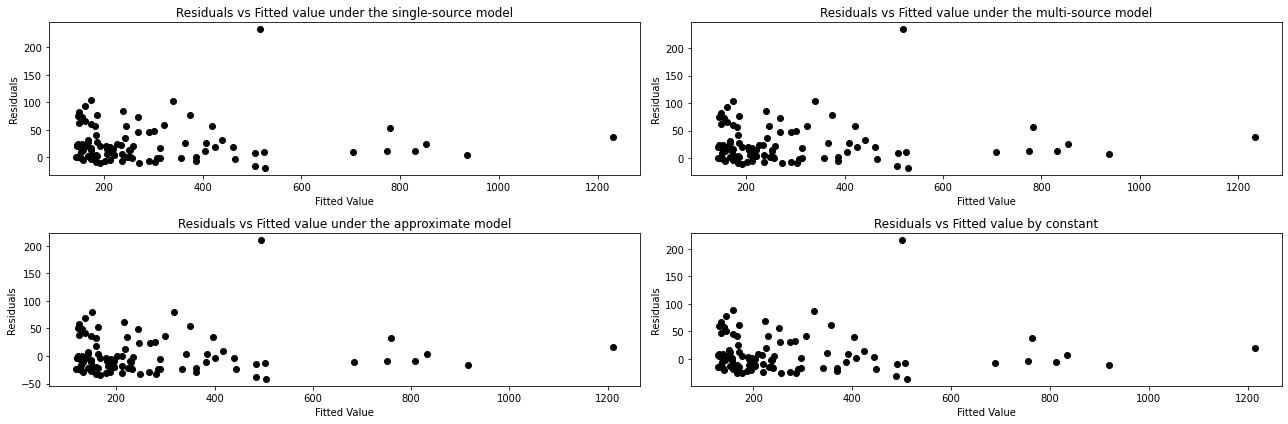

In [81]:
avg_mle = total - n*(-3) * 0.1**(1.5) * (total**(-0.5) - 0.1**(-0.5))
print(avg_mle - brightest)
fig, axes = plt.subplots(2, 2, figsize=(18, 6))

# Plot each subplot
axes[0,0].scatter(mortlock_mle, mortlock_mle - brightest, color='black')
axes[0,0].set_title("Residuals vs Fitted value under the single-source model")
axes[0,0].set_xlabel("Fitted Value")
axes[0,0].set_ylabel("Residuals")

axes[0,1].scatter(mle, mle - brightest, color='black')
axes[0,1].set_title("Residuals vs Fitted value under the multi-source model")
axes[0,1].set_xlabel("Fitted Value")
axes[0,1].set_ylabel("Residuals")

axes[1,0].scatter(normal_mle, normal_mle - brightest, color='black')
axes[1,0].set_title("Residuals vs Fitted value under the approximate model")
axes[1,0].set_xlabel("Fitted Value")
axes[1,0].set_ylabel("Residuals")

axes[1,1].scatter(avg_mle, avg_mle - brightest, color='black')
axes[1,1].set_title("Residuals vs Fitted value by constant")
axes[1,1].set_xlabel("Fitted Value")
axes[1,1].set_ylabel("Residuals")

# Adjust layout for better spacing
plt.tight_layout()
#plt.savefig("residual-fitted")
# Show the plots
plt.show()


[ 128.02083486  138.1857411   151.87802557  167.92370558  196.17953008
  223.67407756  255.89178711  348.82071363  489.72806568 1214.47637752]


sihu 144.0601012702363
sihu 145.01744949365897
sihu 146.56653497883693
sihu 147.32602960782756
sihu 147.36216869074931
sihu 147.38502864406846
sihu 149.11778351942885
sihu 150.5130574441816
sihu 150.88231254449934
sihu 153.36105186827442
sihu 154.05458999871686
sihu 154.27666010686622
sihu 154.9016279050377
sihu 155.2220577745537
sihu 156.63934448396915
sihu 156.71490509502362
sihu 156.7577010734644
sihu 157.93662189161492
sihu 158.89787145740925
sihu 161.60960184984347
sihu 161.73196887623365
sihu 163.7233324459497
sihu 168.03427390875723
sihu 168.42456218990426
sihu 168.48450386157666
sihu 173.38172593637094
sihu 174.13758255850328
sihu 174.37436780337956
sihu 174.72655671876757
sihu 175.3009548476521
sihu 177.02407282684388
sihu 183.42529754747014
sihu 183.49222700567967
sihu 184.15097799641975
sihu 184.50879690714632
sihu 186.95231920447216
sihu 187.2768116148242
sihu 187.48198476120487
sihu 192.74142476104706
sihu 192.78190708778592
sihu 203.03922401419234
sihu 204.92877662855224


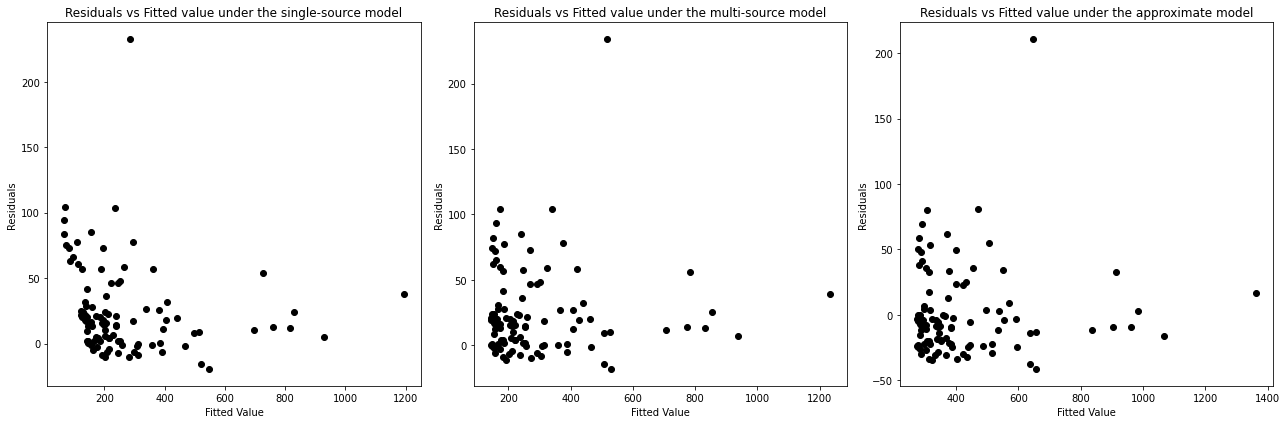

In [44]:


le = np.arange(1, 101, 1)


print(normal_mle[90], mortlock_mle[90], mle[90], brightest[90])
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot each subplot
axes[0].scatter(brightest, mortlock_mle - brightest, color='black')
axes[0].set_title("Residuals vs Fitted value under the single-source model")
axes[0].set_xlabel("Fitted Value")
axes[0].set_ylabel("Residuals")

axes[1].scatter(mle, mle - brightest, color='black')
axes[1].set_title("Residuals vs Fitted value under the multi-source model")
axes[1].set_xlabel("Fitted Value")
axes[1].set_ylabel("Residuals")

axes[2].scatter(total, normal_mle - brightest, color='black')
axes[2].set_title("Residuals vs Fitted value under the approximate model")
axes[2].set_xlabel("Fitted Value")
axes[2].set_ylabel("Residuals")

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("residual-fitted")
# Show the plots
plt.show()

In [73]:
print(np.sum(np.abs(normal_mle - brightest)))
print(np.sum(np.abs(mle - brightest)))
print(np.sum(np.abs(mortlock_mle - brightest)))

2365.3482739135507
2745.611715108369
2742.5909719337233


In [36]:
#Improvement from reporting the total flux instead of each mle estimate 

print((np.sum(np.abs(total- brightest) -np.abs(mle - brightest)))/100)
print((np.sum(np.abs(total- brightest) -np.abs(normal_mle - brightest)))/100)
print((sum(np.abs(total- brightest) -np.abs(mortlock_mle - brightest)))/100)
print(normal_mle[::11])


129.29304060071055
133.09567501265877
129.32324803245706
[ 118.38011952  128.80500301  142.82031095  159.20699107  187.98005962
  215.89738769  248.53648689  342.38045929  484.18302421 1210.83998484]


In [85]:
normal_mle = list(normal_mle)
mle = list(mle)
mortlock_mle = list(mortlock_mle)
avg_mle = list(avg_mle)
avg_mle_excluded = avg_mle[:90] + avg_mle[91:]
normal_mle_excluded = normal_mle[:90] + normal_mle[91:]
mortlock_mle_excluded = mortlock_mle[:90] + mortlock_mle[91:]
mle_excluded = mle[:90] + mle[91:]
brightest_excluded = brightest_flux100[:90] + brightest_flux100[91:]
total_excluded = total_flux100[:90] + total_flux100[91:]

mle_excluded = np.array(mle_excluded)
mortlock_mle_excluded = np.array(mortlock_mle_excluded)
normal_mle_excluded = np.array(normal_mle_excluded)
total_excluded = np.array(total_excluded)
avg_exclude = np.array(avg_mle_excluded)
brightest_excluded = np.array(brightest_excluded)
print(np.mean(np.abs(mle_excluded - brightest_excluded)))
print(np.mean(np.abs(mortlock_mle_excluded-brightest_excluded)))
print(np.mean(np.abs(normal_mle_excluded-brightest_excluded)))
print(np.mean(np.abs(total_excluded - brightest_excluded)))
print(np.mean(np.abs(avg_mle_excluded - brightest_excluded)))

25.368547687832944
25.351564876462398
21.762387860988706
154.65070616965804
20.646084349117988


In [55]:
np.sum(np.abs(brightest - mle) < np.abs(brightest - normal_mle))

38

In [93]:
n=500

tflux, bflux, fdist = analysis(n, m=10000)
tfiltered, bfiltered = remove_above_threshold(tflux, bflux, 9000)
tflux, bflux = sort_linked_lists(tfiltered, bfiltered)
tflux1 = tflux[-20:]
bflux1 = bflux[-20:]

def predict_mean(tflux, n):
    max_flux_prediction = []
    mortlock_mle = []
    normal_mle = []
    mmax_flux_prediction = []
    mmortlock_mle = []
    mnormal_mle = []
    counter = 0
    for flux in tqdm(tflux):
        #True density values
        fluxes, probs = posterior(flux, n)
        mean_val = np.sum(fluxes * probs)
        mmax_flux_prediction.append(mean_val)

        #mortlock posterior MLE 
        mort_fluxes, mort_probs = mortlock_post(flux, n)
        mean_mort = np.sum(mort_fluxes * mort_probs)
        mmortlock_mle.append(mean_mort)

        #Normal Approx MLE
        norm_flux, norm_post = normal_approx(flux, n)
        mean_norm = np.sum(norm_flux * norm_post)
        mnormal_mle.append(mean_norm)
        
        max_ind = np.argmax(probs)
        max_flux_prediction.append(fluxes[max_ind])

        #mortlock posterior MLE 
        mortlock_mle.append(mort_fluxes[np.argmax(mort_probs)])

        #Normal Approx MLE
        normal_mle.append(norm_flux[np.argmax(norm_post)])
        print(counter)
    return max_flux_prediction, mortlock_mle, normal_mle, mmax_flux_prediction, mmortlock_mle, mnormal_mle

pmean, mmean, nmean, a, b, c = predict_mean(tflux1, n)



  5%|▌         | 1/20 [01:28<28:10, 88.96s/it]

sihu 390.05360610895195
0


 10%|█         | 2/20 [02:56<26:27, 88.18s/it]

sihu 397.5741829313953
0


 15%|█▌        | 3/20 [04:23<24:51, 87.75s/it]

sihu 414.8851346628476
0


 20%|██        | 4/20 [05:50<23:19, 87.47s/it]

sihu 433.5569449134439
0


 25%|██▌       | 5/20 [07:18<21:51, 87.41s/it]

sihu 441.99937651709104
0


 30%|███       | 6/20 [08:47<20:30, 87.92s/it]

sihu 447.3064342177537
0


 35%|███▌      | 7/20 [10:16<19:08, 88.34s/it]

sihu 464.99778579903443
0


 40%|████      | 8/20 [11:47<17:51, 89.27s/it]

sihu 465.77059351117214
0


 45%|████▌     | 9/20 [13:13<16:11, 88.34s/it]

sihu 549.8501613466954
0


 50%|█████     | 10/20 [14:40<14:39, 87.90s/it]

sihu 593.1024619056165
0


 55%|█████▌    | 11/20 [16:15<13:29, 89.99s/it]

sihu 628.004796519959
0


 60%|██████    | 12/20 [17:50<12:11, 91.45s/it]

sihu 813.973473025182
0


 65%|██████▌   | 13/20 [19:23<10:43, 91.89s/it]

sihu 1386.2192715424255
0


 70%|███████   | 14/20 [20:55<09:12, 92.14s/it]

sihu 1724.6832621499186
0


 75%|███████▌  | 15/20 [22:29<07:42, 92.54s/it]

sihu 1757.1519444921826
0


 80%|████████  | 16/20 [24:01<06:10, 92.53s/it]

sihu 1783.3585989990602
0


 85%|████████▌ | 17/20 [25:36<04:39, 93.10s/it]

sihu 2032.1068264050155
0


 90%|█████████ | 18/20 [27:08<03:05, 92.79s/it]

sihu 2212.315478474516
0


 95%|█████████▌| 19/20 [28:42<01:33, 93.10s/it]

sihu 2457.4988594954384
0


100%|██████████| 20/20 [30:16<00:00, 90.82s/it]

sihu 2660.354370693943
0


In [113]:
n=500

tflux, bflux, fdist = analysis(n, m=1000)
tfiltered, bfiltered = remove_above_threshold(tflux, bflux, 9000)
tflux, bflux = sort_linked_lists(tfiltered, bfiltered)
tflux1 = tflux[750:800]
bflux1 = bflux[750:800]

def predict_mean(tflux, n):
    max_flux_prediction = []
    mortlock_mle = []
    normal_mle = []
    mmax_flux_prediction = []
    mmortlock_mle = []
    mnormal_mle = []
    counter = 0
    for flux in tqdm(tflux):
        #True density values
        fluxes, probs = posterior(flux, n)
        mean_val = np.sum(fluxes * probs)/(fluxes[-1] - fluxes[0])
        mmax_flux_prediction.append(mean_val)

        #mortlock posterior MLE 
        mort_fluxes, mort_probs = mortlock_post(flux, n)
        mean_mort = np.sum(mort_fluxes * mort_probs)/(mort_fluxes[-1] - mort_fluxes[0])
        mmortlock_mle.append(mean_mort)

        #Normal Approx MLE
        norm_flux, norm_post = normal_approx(flux, n)
        mean_norm = np.sum(norm_flux * norm_post)/(norm_flux[-1] - norm_flux[0])
        mnormal_mle.append(mean_norm)
        
        max_ind = np.argmax(probs)
        max_flux_prediction.append(fluxes[max_ind])

        #mortlock posterior MLE 
        mortlock_mle.append(mort_fluxes[np.argmax(mort_probs)])

        #Normal Approx MLE
        normal_mle.append(norm_flux[np.argmax(norm_post)])
        print(counter)
    return max_flux_prediction, mortlock_mle, normal_mle, mmax_flux_prediction, mmortlock_mle, mnormal_mle

pmean_l, mmean_l, nmean_l, a_l, b_l, c_l = predict_mean(tflux1, n)



  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/zh/7zp_8xb91cj2g3jy1m3w7kp40000gn/T/ipykernel_78528/1111779111.py:157: RuntimeWarning: invalid value encountered in true_divide
  pdf_values_full = pdf_values_full/np.sum(pdf_values)
  2%|▏         | 1/50 [01:27<1:11:27, 87.50s/it]

sihu 22.94050536181706
0


  4%|▍         | 2/50 [02:53<1:09:22, 86.71s/it]

sihu 22.985092897910533
0


  6%|▌         | 3/50 [04:18<1:07:18, 85.93s/it]

sihu 23.082153934581356
0


  8%|▊         | 4/50 [05:43<1:05:29, 85.42s/it]

sihu 23.138152219908108
0


 10%|█         | 5/50 [07:08<1:04:00, 85.35s/it]

sihu 23.14642320616761
0


 12%|█▏        | 6/50 [08:33<1:02:35, 85.34s/it]

sihu 23.314400559512535
0


 14%|█▍        | 7/50 [09:59<1:01:17, 85.51s/it]

sihu 23.372487632728593
0


 16%|█▌        | 8/50 [11:26<1:00:03, 85.79s/it]

sihu 23.40380475798375
0


 18%|█▊        | 9/50 [12:50<58:13, 85.20s/it]  

sihu 23.54240800872276
0


 20%|██        | 10/50 [14:13<56:28, 84.71s/it]

sihu 23.628887163805615
0


 22%|██▏       | 11/50 [15:38<55:03, 84.71s/it]

sihu 23.65033538707803
0


 24%|██▍       | 12/50 [17:02<53:37, 84.66s/it]

sihu 23.7202001092883
0


 26%|██▌       | 13/50 [18:30<52:50, 85.69s/it]

sihu 23.76720996625147
0


 28%|██▊       | 14/50 [19:56<51:25, 85.72s/it]

sihu 23.828565405485136
0


 30%|███       | 15/50 [21:25<50:30, 86.59s/it]

sihu 23.899113698047984
0


 32%|███▏      | 16/50 [22:54<49:25, 87.23s/it]

sihu 23.901578705511582
0


 34%|███▍      | 17/50 [24:23<48:24, 88.02s/it]

sihu 23.941894588279496
0


 36%|███▌      | 18/50 [25:55<47:34, 89.20s/it]

sihu 24.04938427350001
0


 38%|███▊      | 19/50 [27:29<46:45, 90.50s/it]

sihu 24.114953672619606
0


 40%|████      | 20/50 [29:03<45:50, 91.68s/it]

sihu 24.126795568570543
0


 42%|████▏     | 21/50 [30:37<44:35, 92.25s/it]

sihu 24.229929088439775
0


 44%|████▍     | 22/50 [32:11<43:18, 92.79s/it]

sihu 24.30875663616675
0


 46%|████▌     | 23/50 [33:45<41:57, 93.25s/it]

sihu 24.471539013485227
0


 48%|████▊     | 24/50 [35:16<40:02, 92.41s/it]

sihu 24.708225166276378
0


 50%|█████     | 25/50 [36:53<39:07, 93.89s/it]

sihu 24.89653008493366
0


 52%|█████▏    | 26/50 [38:29<37:48, 94.50s/it]

sihu 24.909336349697668
0


 54%|█████▍    | 27/50 [40:03<36:09, 94.34s/it]

sihu 25.064168272923098
0


 56%|█████▌    | 28/50 [41:36<34:27, 93.97s/it]

sihu 25.0751766304123
0


 58%|█████▊    | 29/50 [43:08<32:43, 93.50s/it]

sihu 25.238199374013078
0


 60%|██████    | 30/50 [44:40<30:58, 92.94s/it]

sihu 25.23906743664685
0


 62%|██████▏   | 31/50 [46:11<29:11, 92.21s/it]

sihu 25.337047357479463
0


 64%|██████▍   | 32/50 [47:42<27:37, 92.07s/it]

sihu 25.35192524121021
0


 66%|██████▌   | 33/50 [49:14<26:03, 91.98s/it]

sihu 25.627719933804286
0


 68%|██████▊   | 34/50 [50:47<24:35, 92.23s/it]

sihu 25.690786267792475
0


 70%|███████   | 35/50 [52:19<23:02, 92.14s/it]

sihu 25.769662173998455
0


 72%|███████▏  | 36/50 [53:51<21:29, 92.12s/it]

sihu 25.775970289059643
0


 74%|███████▍  | 37/50 [55:23<19:55, 91.99s/it]

sihu 25.928293538893257
0


 76%|███████▌  | 38/50 [56:57<18:33, 92.80s/it]

sihu 25.95234491435312
0


 78%|███████▊  | 39/50 [58:31<17:05, 93.20s/it]

sihu 25.964824099656568
0


 80%|████████  | 40/50 [1:00:06<15:35, 93.51s/it]

sihu 26.001272426409543
0


 82%|████████▏ | 41/50 [1:01:40<14:02, 93.64s/it]

sihu 26.044407203856963
0


 84%|████████▍ | 42/50 [1:03:16<12:36, 94.52s/it]

sihu 26.27767642731473
0


 86%|████████▌ | 43/50 [1:04:50<11:00, 94.41s/it]

sihu 26.284433278095634
0


 88%|████████▊ | 44/50 [1:06:21<09:19, 93.20s/it]

sihu 26.39302920346509
0


 90%|█████████ | 45/50 [1:07:48<07:37, 91.41s/it]

sihu 26.61542438095924
0


 92%|█████████▏| 46/50 [1:09:26<06:13, 93.35s/it]

sihu 26.732375853750142
0


 94%|█████████▍| 47/50 [1:11:31<05:08, 102.91s/it]

sihu 26.839110856076104
0


 96%|█████████▌| 48/50 [1:13:34<03:38, 109.06s/it]

sihu 26.860451634147097
0


 98%|█████████▊| 49/50 [1:15:04<01:43, 103.25s/it]

sihu 26.90947616780062
0


100%|██████████| 50/50 [1:16:35<00:00, 91.90s/it] 

sihu 27.342692448308412
0
